In [6]:
# Imports and some general settings

import numpy as np
import matplotlib.pyplot as plt
#from scipy.interpolate import interp1d
import ipywidgets as widgets


# to make plots with interactive zooms etc
%matplotlib widget
# for exporting, to keep the figures you must make figures static:
#%matplotlib inline

plt.style.use('bmh') #matplotlib default style, looks better.
#plt.rcParams['lines.linewidth'] = 1.5 #default linewidth
#plt.rcParams['figure.dpi']= 300 #this is for figure default resolution, increase to 200 or 300 for final figure generation, but keep the default value for working

c=2.99792458E8

In [7]:
def MZI_resp(w,neff,dL):
    """Intensity response of a single MZI in linear units. It assumes two identical couplers with 50% coupling coefficient.
    w: the wavelength (any units)
    neff: effective index, if number, a constant, if vector, a variable as sampled on w
    L1: length of branch 1
    dL: length difference L2-L1
    dT: global temperature variation (K)
    dndT: thermo-optic coefficient (K^-1)
    wavelengths and lengths can have any units, but must be the same.
    """
    
    L1=0
    #if neff is 2D but w is 1D, I have to spread w along a second dimension
    if neff.ndim > w.ndim:
        w=np.matmul(np.reshape(w,(len(w),1)),np.ones([1,np.shape(neff)[1]]))

    k_0 = 2*np.pi/w
    E_out = .5*(np.exp(1j*k_0*neff*(L1+dL))+np.exp(1j*k_0*neff*L1))
    return np.abs(E_out)**2



In [8]:
def ringres_resp(w,neff,K,L,A=1.):
    """Add-drop ring resonator response in linear units.
    L: is the perimeter of the ring.
    K: is the energy coupling coefficient of both couplers. If a list, it is the coefficient of each coupler, to be used if they are different.
    A: is the energy attenuation coefficient of the ring excluding the couplers. If =1, means loss is negligible.
    Returns: drop and thru in linear scale.
    Equations were taken from Bogaerts et al, Laser & Phot. reviews 6 (2012)"""
    
    if not(isinstance(K, list)): #if not a list, make them both the same
        K1=K
        K2=K
    else:
        K1=K[0]
        K2=K[1]
    
    R1=1-K1
    R2=1-K2
    r1=np.sqrt(R1)
    r2=np.sqrt(R2)
    a=np.sqrt(A)
    cosphi = np.cos(2*np.pi/w*neff*L)
    denom = 1-2*r1*r2*a*cosphi+(r1*r2*a)**2
    
    thru=(r2**2*a**2-2*r1*r2*a*cosphi+r1**2)/denom
    drop=(1-r1**2)*(1-r2**2)*a/denom
    return drop, thru

In [9]:
def neff_calc(w0,neff0,ng0,w):
    """Calculates the neff vector given the effective and group indices at one specific wavelength.
    w0, neff0, ng0 are the central wavelength, neff and ng.
    w is the wavelength vector to calculate all neffs."""
    neff = neff0 + (neff0-ng0)/w0*(w-w0)
    return neff
    

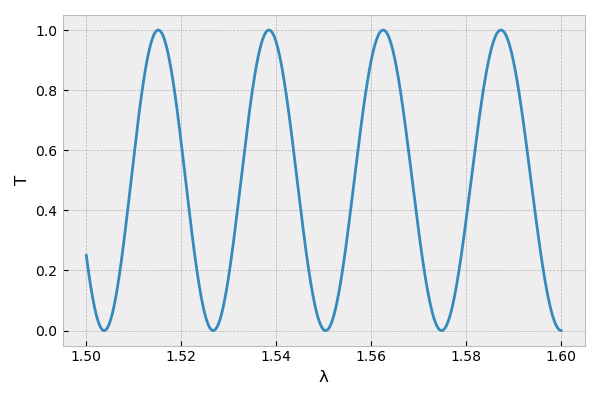

In [10]:
layout_slider=widgets.Layout(width='350px')


dL21_slider = widgets.FloatSlider(value = 50., min = 0., max = 1000., step=1E-2,
                                 continuous_update = True,
                                 description = 'Delta L',
                                 layout = layout_slider)

neff_slider = widgets.FloatSlider(value = 2.0, min = 1., max = 4., step=1E-3,
                                 continuous_update = True,
                                 description = 'neff',
                                 layout = layout_slider)

dT_slider = widgets.FloatSlider(value = 0., min = -100., max = 100., step=1E-2,
                                 continuous_update = True,
                                 description = 'Delta T(K)',
                               layout = layout_slider)
all_sliders_MZI = [dL21_slider,neff_slider,dT_slider]

R_slider = widgets.FloatSlider(value = 5., min = 2., max = 50., step=1E-2,
                                 continuous_update = True,
                                 description = 'R',
                                 layout = layout_slider)

K_slider = widgets.FloatSlider(value = .1, min = .01, max = 1., step=1E-3,
                                 continuous_update = True,
                                 description = 'K',
                                 layout = layout_slider)


all_sliders_ring = [R_slider,K_slider,neff_slider,dT_slider]

layout_text = widgets.Layout(width = "150px")
style = {'description_width': '65px'}
ng_eff_text = widgets.FloatText(min = -5, max = 5, step = 0.001, value = 0, layout=layout_text, 
                   description = 'ng-neff',style = style)
w1_text = widgets.FloatText(min = .01, max = 5., step = 0.001, value = 1.5, layout=layout_text,
                   description = '\u03BB min',style = style)
w2_text = widgets.FloatText(min = .01, max = 5., step = 0.001, value = 1.6, layout=layout_text,
                   description = '\u03BB max',style = style)
w0_text = widgets.FloatText(min = .01, max = 5., step = 0.001, value = 1.55, layout=layout_text,
                   description = '\u03BB0',style = style)
Nw_text = widgets.IntText(min = 100, max = 10000, step = 1, value = 1000, layout=layout_text,
                   description = 'Num. \u03BB',style = style)
dndT_text = widgets.FloatText(min = -1, max = 1, step = 1E-6, value = 1.8E-4, layout=layout_text,
                              readout_format='.3e',
                              description = 'dneff/dT',style = style)
info_label = widgets.Label()


all_texts = [ng_eff_text,w1_text,w2_text,w0_text,Nw_text,dndT_text]

sliders_col_MZI = widgets.VBox(all_sliders_MZI)
sliders_col_ring = widgets.VBox(all_sliders_ring)

text_col = widgets.VBox([widgets.HBox([w1_text,w2_text]),
                         widgets.HBox([w0_text,Nw_text]),
                         widgets.HBox([ng_eff_text,dndT_text]),
                         info_label])

ctrls_MZI = widgets.HBox([sliders_col_MZI,text_col])
ctrls_ring = widgets.HBox([sliders_col_ring,text_col])

layout_center =  widgets.Layout(display = 'flex',
                                align_items = 'center')

file = open("MZI_white.png", "rb")
image = file.read()
img_MZI = widgets.Image(
    value=image,
    format='png',
    width = 200)
file = open("ring_white.png", "rb")
image = file.read()
img_ring = widgets.Image(
    value=image,
    format='png',
    width = 200)


text_MZI = """Here you can simulate a Mach-Zehnder interferometer.
              On the left you can set the path diference $\Delta L$, the effective index $n_{eff}$ and the temperature change $\Delta T$;
              and on the right the wavelength constraints 
              and the material parameters $n_g-n_{eff}$ and $dn_{eff}/dT$. The unit for lengths are in principle microns, but could be any
              as long as they are consistent for wavelengths and for distances."""

text_ring = """Here you can simulate a ring resonator with symmetric add and drop couplers and negligible loss.
              On the left you can set the ring radius $R$, the effective index $n_{eff}$ the energy coupling coefficient $K$ and the temperature change $\Delta T$;
              on the right you can change the wavelength constraints and the material parameters $n_g-n_{eff}$ and $dn_{eff}/dT$.
              The free-spectral range (FSR) and the full-width at half maximum (FWHM) of the peaks are also indicated numerically.
              The unit for lengths are in principle microns, but could be any
              as long as they are consistent for wavelengths and for distances."""

text_MZI_label = widgets.HTMLMath(value= '<style>p{word-wrap: break-word}</style> <p>'+ text_MZI +' </p>')
text_ring_label = widgets.HTMLMath(value= '<style>p{word-wrap: break-word}</style> <p>'+ text_ring +' </p>')

#text_MZI_label = widgets.Label(text_MZI)
all_MZI = widgets.VBox([img_MZI,text_MZI_label,ctrls_MZI],layout = layout_center)
all_ring = widgets.VBox([img_ring,text_ring_label,ctrls_ring],layout = layout_center)

children = [all_MZI, all_ring]

tab = widgets.Tab(layout = widgets.Layout(width = '700px'))
#tab = widgets.Tab()
tab.children = children
tab_titles = ['Mach-Zehnder','Ring resonator']
for ii,title in enumerate(tab_titles):
    tab.set_title(ii,title)
display(tab)




fig, ax = plt.subplots(figsize = (6,4))
fig.canvas.header_visible = False


def update(change):
    w0 = w0_text.value
    w = np.linspace(w1_text.value,w2_text.value,Nw_text.value)
    neff0 = neff_slider.value+dT_slider.value*dndT_text.value
    ng0 = neff0+ng_eff_text.value
    neff_vec = neff_calc(w0=w0,neff0=neff0,ng0=ng0,w=w)
    
    if tab.selected_index == 0:
        
        if dL21_slider.value != 0:
            FSR = w0**2/(ng0*dL21_slider.value)
            info_label.value = f'FSR = {FSR:.5g}'
        else:
            info_label.value = 'FSR = Inf.'
        out = MZI_resp(w=w,neff=neff_vec,dL=dL21_slider.value)
        ax.clear()
        ax.plot(w,out)
        ax.set_xlabel('\u03BB')
        ax.set_ylabel('T')
        ax.set_ylim([-.05,1.05])
        
    else:
        L=2*np.pi*R_slider.value
        K = K_slider.value
        FSR =  w0**2/(ng0*L)
        FWHM = K/(np.pi*np.sqrt(1-K))*FSR
        if FWHM < FSR/3:
            info_label.value = f'FSR = {FSR:.5g}, FWHM \u2248 {FWHM:.5g}'
        else:
            info_label.value = f'FSR = {FSR:.5g}'
        out_drop, out_thru = ringres_resp(w=w,neff=neff_vec,K=K,L=L)
        ax.clear()
        ax.plot(w,out_drop,w,out_thru)
        ax.set_xlabel('\u03BB')
        ax.set_ylabel('T')
        ax.legend(['Drop','Through'],loc='center right')
        ax.set_ylim([-.05,1.05])
    
    fig.canvas.draw()

    
update(None)
fig.tight_layout()

[sl.observe(update,'value') for sl in all_sliders_MZI+all_sliders_ring+all_texts]
tab.observe(update,names = 'selected_index')
None
    

    
    